# Used Car Sale Auction Prices
By Sky Reznik, John Lackey and Kevin Abatto

Import packages

In [26]:

import pandas as pd; 
import numpy as np; 
from sklearn.preprocessing import OneHotEncoder;
import os;
from kaggle.api.kaggle_api_extended import KaggleApi;

Download data using Kaggle KPI

In [27]:
# Specify the dataset and the path to save it
dataset_name = 'tunguz/used-car-auction-prices'  # Replace with your actual Kaggle dataset name
download_path = './kaggle_datasets'     # Folder to store the dataset

# Create download path if it doesn't exist
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Check if file exists
dataset_file_path = os.path.join(download_path, 'car_prices.csv')   
# Check if the dataset already exists in the folder
if not os.path.exists(dataset_file_path):
    # Initialize the Kaggle API
    api = KaggleApi()
    api.authenticate()  # Authenticate using your Kaggle credentials

    # Download the dataset
    print(f"Downloading {dataset_name}...")
    api.dataset_download_files(dataset_name, path=download_path, unzip=True)

    print("Download complete.")
else:
    print("Dataset already exists, download skipped.")

# Load CSV into a pandas dataframe
shared_file_path = './kaggle_datasets/car_prices.csv'
# line 408,163 - "Model" field contains a comma (SE PZEV w/Connectivity, Navigation) - specify quotechar='"'
# This tells Pandas to treat anything inside double quotes as a single field, even if it contains commas.
#      solution provided by ChatGPT
df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')
df.head()

Dataset already exists, download skipped.


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


# Data Cleaning
__Done__
1) Remove any row with missing data with df.dropna()
2) One-Hot encode ['transmission'] to ['automatic_trans'] 0 /1 (double check unique vals)
3) Simplify ['body'] (collapse all 85 body types to 9 types)
4) Convert ['saledate']
5) Age of car (from ['saledate'])


In [28]:
print("Start: ", df.shape)

# 1 - Remove rows with missing values
df = df.dropna()

# 2 - One-hot encode the 'transmission' column
print(df['transmission'].unique())
df['auto_transmission'] = np.where(df['transmission'].str.contains('automatic', case=False), 1, 0)

# 3 - One-hot encode the 'body' column (count 85 unique values --> reduce to 8)
# ['suv' 'sedan' 'convertible' 'coupe' 'wagon' 'hatchback' 'truck' 'minivan' 'van']
print(df['body'].unique())
df['body_type'] = np.nan
df['body_type'] = np.where(df['body'].str.contains('minivan', case=False), 'minivan', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('sedan', case=False), 'sedan', df['body'])
df['body_type'] = np.where(df['body'].str.contains('wagon', case=False), 'wagon', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('coupe', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('koup', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('convertible', case=False), 'convertible', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('hatchback', case=False), 'hatchback', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains(r'\bvan\b', case=False), 'van', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('truck', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('cab', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('crew', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('suv', case=False), 'suv', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('Minivan', case=False), 'minivan', df['body_type'])
print(df['body_type'].unique())

# 4 - Converting 'saledate' to datetime (solution provided by ChatGPT)
df['saledate'] = pd.to_datetime(df['saledate'].str[4:24], format="%b %d %Y %H:%M:%S")

# 5 - Create a new column 'car_age' by subtracting 'year' from 'saledate'
df['car_age'] = df['saledate'].dt.year - df['year']

# Drop old columns
df.drop('transmission', axis=1, inplace=True)
df.drop('body', axis=1, inplace=True)
print("Finish: ", df.shape)
print(df.head())


Start:  (558811, 16)
['automatic' 'manual']
['SUV' 'Sedan' 'Convertible' 'Coupe' 'Wagon' 'Hatchback' 'Crew Cab'
 'G Coupe' 'G Sedan' 'Elantra Coupe' 'Genesis Coupe' 'Minivan' 'Van'
 'Double Cab' 'CrewMax Cab' 'Access Cab' 'King Cab' 'CTS Coupe'
 'SuperCrew' 'E-Series Van' 'Extended Cab' 'SuperCab' 'G Convertible'
 'Koup' 'Regular Cab' 'Quad Cab' 'CTS-V Coupe' 'sedan' 'G37 Convertible'
 'Club Cab' 'Xtracab' 'Q60 Convertible' 'CTS Wagon' 'G37 Coupe' 'Mega Cab'
 'Cab Plus 4' 'Q60 Coupe' 'Beetle Convertible' 'TSX Sport Wagon'
 'Promaster Cargo Van' 'Cab Plus' 'GranTurismo Convertible' 'CTS-V Wagon'
 'Ram Van' 'convertible' 'minivan' 'Transit Van' 'van' 'regular-cab' 'suv'
 'g sedan' 'g coupe' 'hatchback' 'king cab' 'supercrew' 'g convertible'
 'coupe' 'crew cab' 'wagon' 'e-series van' 'regular cab' 'quad cab'
 'g37 convertible' 'supercab' 'extended cab' 'crewmax cab' 'double cab'
 'genesis coupe' 'access cab' 'mega cab' 'xtracab' 'beetle convertible'
 'cts coupe' 'koup' 'club cab' 'elantra

In [29]:
print(df['body_type'].unique())

['suv' 'sedan' 'convertible' 'coupe' 'wagon' 'hatchback' 'truck' 'minivan'
 'van']


mapping body type by size of vehicle

In [30]:
size_mapping = {
    'convertible': 0,
    'coupe': 1,
    'hatchback': 2,
    'sedan': 3,
    'wagon': 4,
    'suv': 5,
    'minivan': 6,
    'truck': 7,
    'van': 8
}

df['body_size'] = df['body_type'].map(size_mapping)


# Data Vizualization
Plot 'mmr' v. 'sellingprice'

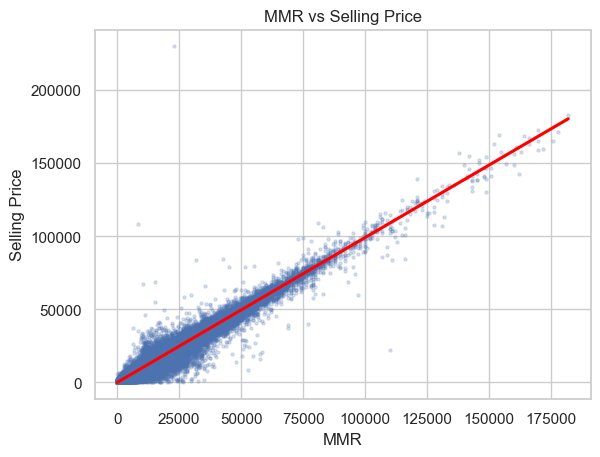

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set the style of seaborn
sns.set(style="whitegrid")
plt.scatter(df['mmr'], df['sellingprice'], alpha=0.2, s=5) # Create a scatter plot
sns.regplot(x='mmr', y='sellingprice', data=df, scatter=False, color='red') # Linear fit line
plt.title('MMR vs Selling Price')
plt.xlabel('MMR')
plt.ylabel('Selling Price')
plt.show()

# Scatterplot is showing some outlires, let's take a closer look at the data to find and remove them
1. Identify outliers
2. Explain in Markdown

In [32]:
outliers_rows = df.index[
    ((df['mmr'] > 100000) | (df['sellingprice'] > 100000)) &
    ((df['mmr'] > df['sellingprice'] * 2) | (df['mmr'] < df['sellingprice'] * 0.5))
].tolist()

print("Outliers: ", outliers_rows)
df.loc[outliers_rows]

Outliers:  [160201, 344905, 405316]


,year,make,model,trim,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,auto_transmission,body_type,car_age,body_size
160201,2010,Ford,Escape,XLT,1fmcu0d77aka54695,oh,3.7,82985.0,red,gray,pat obrien chevrolet south,8250,108200,2015-01-20 01:30:00,1,suv,5,5
344905,2014,Ford,Escape,Titanium,1fmcu9j98eua23833,mo,4.3,27802.0,green,tan,ford-lincoln dealer program,22800,230000,2015-02-25 02:00:00,1,suv,1,5
405316,2013,Mercedes-Benz,G-Class,G63 AMG,wdcyc7df0dx200577,pa,4.8,23947.0,black,black,adcock brothers inc,110000,22250,2015-03-20 02:00:00,1,suv,2,5


Line 160201:

2010 Ford Escape valued by MMR at \$8250 sold for \$108200, this seems like a data entry error, it is much more likely it sold for $8200

Line 344905:

2014 Ford Escape valued by MMR at \$22800 sold for \$230000, this seems like a data entry error, it is much more likely it sold for $23000

Line 405316:

2013 Mercedes-Benz G63 AMG valued by MMR at \$110000 sold for \$22250, this is hard to decifer. Not sure. 

# Using features to predict selling price
List of numeric features:
1. year
2. condition
3. odometer
4. auto_transmission
5. car_age

In [33]:
df_predictor = df[['year', 'condition', 'odometer', 'auto_transmission', 'car_age']]